<a href="https://colab.research.google.com/github/jyosa/MachineLearning001/blob/main/PINN1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torch.func import functional_call, grad, vmap
import numpy as np

# Define the neural network architecture
class LinearNN(nn.Module):
    def __init__(self, num_inputs=1, num_layers=1, num_neurons=5, act=nn.Tanh()):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_neurons = num_neurons
        self.num_layers = num_layers

        layers = [nn.Linear(self.num_inputs, num_neurons)]
        for _ in range(num_layers):
            layers.extend([nn.Linear(num_neurons, num_neurons), act])
        layers.append(nn.Linear(num_neurons, 1))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x.reshape(-1, 1)).squeeze()

# Define the analytical solution for logistic growth
def logistic_growth(t, R, K, P0):
    return K / (1 + ((K - P0) / P0) * np.exp(-R * t))

# Function to convert model parameters to a dictionary
def get_params_dict(model):
    return {name: param for name, param in model.named_parameters()}

# Initialize the model and get the initial parameters as a dictionary
model = LinearNN(num_layers=3, num_neurons=10)
params_dict = get_params_dict(model)

# Functions for computing higher order gradients
def f(x, params_dict):
    return functional_call(model, params_dict, (x,))

dfdx = vmap(grad(f), in_dims=(0, None))

# Parameters for the loss function and logistic growth model
R = 1.0  # Growth rate parameter
K = 1.0  # Carrying capacity
P0 = 0.5  # Initial population size
X_BOUNDARY = 0.0  # Boundary condition coordinate
F_BOUNDARY = P0  # Boundary condition value

# Loss function
def loss_fn(params_dict, x, y_analytical):
    f_value = f(x, params_dict)
    interior = dfdx(x, params_dict) - R * f_value * (1 - f_value)
    data_loss = nn.MSELoss()(f_value, y_analytical)

    x_boundary = torch.tensor([X_BOUNDARY])
    f_boundary = torch.tensor([F_BOUNDARY])
    boundary = f(x_boundary, params_dict) - f_boundary

    loss = nn.MSELoss()
    return loss(interior, torch.zeros_like(interior)) + loss(boundary, torch.zeros_like(boundary)) + data_loss

# Training loop configuration
batch_size = 30
num_iter = 500
learning_rate = 1e-1
domain = (0.0, 10.0)  # Adjusted domain

# Generate 2000 sample points
sample_points = torch.linspace(domain[0], domain[1], 2000)
analytical_solutions = logistic_growth(sample_points.numpy(), R, K, P0)

# Train the model
for i in range(num_iter):
    indices = torch.randperm(sample_points.size(0))[:batch_size]
    x = sample_points[indices]
    y_analytical = torch.tensor(analytical_solutions[indices], dtype=torch.float32)

    loss = loss_fn(params_dict, x, y_analytical)

    grads = torch.autograd.grad(loss, params_dict.values(), create_graph=True)
    with torch.no_grad():
        for (name, param), grad in zip(params_dict.items(), grads):
            param -= learning_rate * grad
            params_dict[name] = param

    if i % 10 == 0:
        print(f"Iteration {i} with loss {float(loss)}")


Iteration 0 with loss 2.3279261589050293
Iteration 10 with loss 0.015172984451055527
Iteration 20 with loss 0.0011610250221565366
Iteration 30 with loss 0.000543293310329318
Iteration 40 with loss 0.0003760805702768266
Iteration 50 with loss 0.00023561911075375974
Iteration 60 with loss 0.00022346829064190388
Iteration 70 with loss 0.00015980310854502022
Iteration 80 with loss 0.00017135054804384708
Iteration 90 with loss 0.000167809848790057
Iteration 100 with loss 9.712605969980359e-05
Iteration 110 with loss 0.00015349344175774604
Iteration 120 with loss 0.00011970098421443254
Iteration 130 with loss 0.00012887796037830412
Iteration 140 with loss 5.2146649977657944e-05
Iteration 150 with loss 0.00012895572581328452
Iteration 160 with loss 6.91752356942743e-05
Iteration 170 with loss 0.0001405863877153024
Iteration 180 with loss 0.00015394591900985688
Iteration 190 with loss 0.00019676776719279587
Iteration 200 with loss 7.169181481003761e-05
Iteration 210 with loss 7.290835492312908

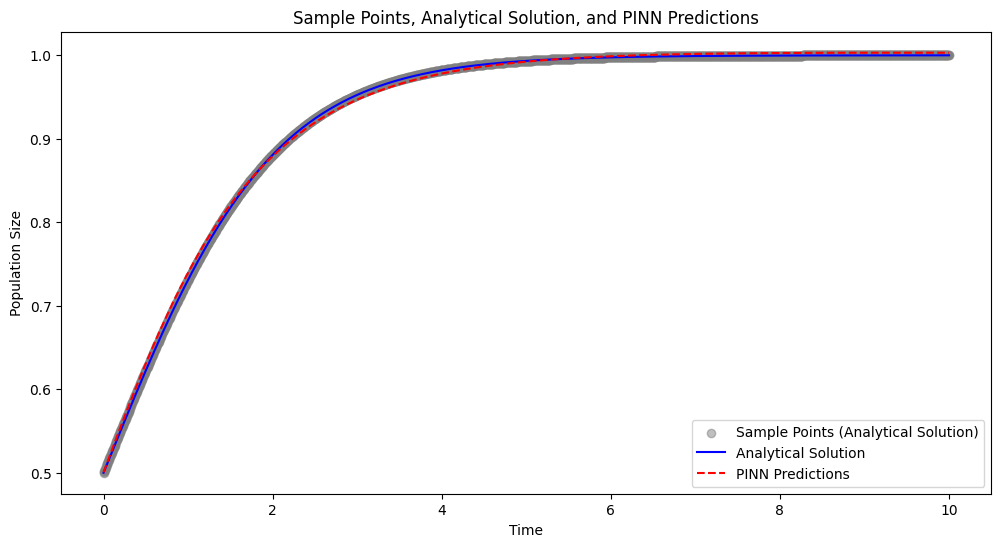

In [ ]:
import matplotlib.pyplot as plt

# Calculate the analytical solution over a range of points for plotting
t_plot = torch.linspace(domain[0], domain[1], 500).numpy()
analytical_solution_plot = logistic_growth(t_plot, R, K, P0)

# Use the trained model to predict the PINN solution over the same range
t_tensor_plot = torch.tensor(t_plot, dtype=torch.float32)
with torch.no_grad():
    pinn_solution_plot = f(t_tensor_plot, params_dict).numpy()

# Plotting the sample points, analytical solution, and PINN predictions
plt.figure(figsize=(12, 6))
plt.scatter(sample_points, analytical_solutions, color='gray', alpha=0.5, label='Sample Points (Analytical Solution)')
plt.plot(t_plot, analytical_solution_plot, label='Analytical Solution', color='blue')
plt.plot(t_plot, pinn_solution_plot, label='PINN Predictions', linestyle='dashed', color='red')
plt.xlabel('Time')
plt.ylabel('Population Size')
plt.title('Sample Points, Analytical Solution, and PINN Predictions')
plt.legend()
plt.show()
